# Find auxtel slew and block times

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from astropy.time import Time, TimeDelta

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site

from lsst_efd_client import EfdClient
import requests
import urllib

In [13]:
# On the RSP, access token available from lsst.rsp
try:
    from lsst.rsp import get_access_token
# But otherwise ..
except ImportError:
    def get_access_token(token_file : str | None = None) -> str:
        if token_file is not None:
            with open(token_file, "r") as f:
                token = f.read()
                token = token.rstrip("\n")
        else:
            token = os.environ.get("ACCESS_TOKEN")
        if token is None:
            warnings.warn("No RSP token available.")
        return token

def get_clients(token_file : str | None = None) -> dict:
    """Return site-specific client connections. 

    Parameters
    ----------
    token_file : `str` or None
        File containing an RSP token.

    Returns
    -------
    endpoints : `dict`
        Dictionary with `efd`, `obsenv`, 
        `narrative_log`, and `exposure_log`
        connection information.
        For the obsenv, narrative log and exposure log, these are only
        defined for the summit or USDF.

    Note
    ----
    The authentication token required to access the log services
    is an RSP token, and is RSP site-specific. 
    For users outside the RSP, a token can be created as described in
    https://nb.lsst.io/environment/tokens.html
    """
    # Set up authentication
    token = get_access_token(token_file)
    auth = ("user", token)
    # This authentication is for nightlog, exposurelog, nightreport currently
    # But I think it's the same underlying info for EfdClient i.e.
    # https://github.com/lsst/schedview/blob/e11fbd51ee5e22d11fef9a52f66dfcc082181cb6/schedview/app/scheduler_dashboard/influxdb_client.py
    # For lots more information on rubin tokens see DMTN-234.
    # For information on scopes, see DMTN-235.
    
    # let's do this like lsst.summit.utils.getSite but simpler
    site = "UNKNOWN"
    location = os.getenv("EXTERNAL_INSTANCE_URL", "")
    if "tucson-teststand" in location:
        site = "tucson"
    elif "summit-lsp" in location:
        site = "summit"
    elif "base-lsp" in location:
        site = "base"
    elif "usdf-rsp" in location:
        site = "usdf"
    # If location not set, next step is to check hostname
    elif location == "":
        hostname = os.getenv("HOSTNAME", "")
        interactiveNodes = ("sdfrome", "sdfiana")
        if hostname.startswith(interactiveNodes):
            site = "usdf"
        elif hostname == "htcondor.ls.lsst.org":
            site = "base"
        elif hostname == "htcondor.cp.lsst.org":
            site = "summit"

    
    if site == "summit":
        api_base = "https://summit-lsp.lsst.codes"
        efd_client = EfdClient("summit_efd")
        obsenv_client = EfdClient("summit_efd", db_name="lsst.obsenv")
    elif site == "tucson":
        api_base = None
        efd_client = EfdClient("tucson_teststand_efd")
        obsenv_client = EfdClient("tucson_teststand_efd", db_name="lsst.obsenv")
    elif site == "base":
        api_base = "https://base-lsp.slac.lsst.codes"
        efd_client = EfdClient("base_efd")
        obsenv_client = EfdClient("base_efd", db_name="lsst.obsenv")
    elif site == "usdf":
        # For tokens, need to distinguish between dev and prod
        if "dev" in location:
            api_base = "https://usdf-rsp-dev.slac.stanford.edu"
        else:
            api_base = "https://usdf-rsp.slac.stanford.edu"
        efd_client = EfdClient("usdf_efd")
        obsenv_client = EfdClient("usdf_efd", db_name='lsst.obsenv')
        # Also set up some env variables.
        os.environ["no_proxy"] += ",.consdb"
        os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"
    else:
        # Assume USDF prod (for any UNKNOWN)
        efd_client = EfdClient("usdf_efd")
        obsenv_client = EfdClient("usdf_efd", db_name='lsst.obsenv')
        api_base = "https://usdf-rsp.slac.stanford.edu"
    
    narrative_log =  "/narrativelog/messages"
    exposure_log = "/exposurelog/messages"
    nightreport =  "/nightreport/reports"
    consdb_query = "/consdb/query"
    
    endpoints = {'api_base': api_base, 'auth': auth, 
                'efd': efd_client, 'obsenv': obsenv_client, 
                'consdb': consdb_query,
                'narrative_log': narrative_log, 'exposure_log': exposure_log,  
                'nightreport': nightreport}
    
    # If some verbose output is desired
    # We'll put this here to make it easier to avoid printing the auth token
    endpoints_string = f"base url: {endpoints['api_base']} " 
    endpoints_string += f"efd host: {endpoints['efd'].influx_client.host}"
    endpoints['string'] = endpoints_string

    return endpoints


def query_logging_services(endpoint: str, auth: tuple, params: dict) -> pd.DataFrame:
    """Send `get` query to logging services. 
    
    Parameters
    ----------
    endpoint : `str`
        The URL to send the query to.
        Usually like `https://usdf-rsp.slac.stanford.edu/narrativelog/messages`
    auth : `tuple`
        The username and password for authentication.
        The username can be any string, the password should be an RSP token.
        See e.g. https://nb.lsst.io/environment/tokens.html 
    params : `dict`
        Dictionary of parameters for the REST API query.
        See docs for each service for more details.

    Returns
    -------
    messages : `pd.DataFrame`
        The returned log messages (if any available), in a dataframe.
    """
    # Very often, requests from the logging endpoints fail the first time.
    response = requests.get(endpoint, auth=auth, params=params)
    # Try twice.
    if response.status_code != 200:
        response = requests.get(endpoint, auth=auth, params=params)
    if response.status_code != 200:
        err_string = f"{endpoint} "
        err_string += " unavailable."
        print(response)
        print(err_string)
        messages = []
    else:
        messages = response.json()
    messages = pd.DataFrame(messages)
    return messages

def query_consdb(endpoint: str, auth: tuple, params: dict) -> pd.DataFrame:
    """Send `post` query to consdb.
    
    Parameters
    ----------
    endpoint : `str`
        The URL to send the query to.
        Usually like `https://usdf-rsp.slac.stanford.edu/consdb/query`
    auth : `tuple`
        The username and password for authentication.
        The username can be any string, the password should be an RSP token.
        See e.g. https://nb.lsst.io/environment/tokens.html 
    params : `dict`
        Dictionary of parameters for the REST API query.
        See docs for each service for more details.

    Returns
    -------
    messages : `pd.DataFrame`
        The returned visits information (if any available), in a dataframe.
    """
    # Very often, requests from the logging endpoints fail the first time.
    response = requests.post(endpoint, auth=auth, json=params)
    # Try twice.
    if response.status_code != 200:
        response = requests.post(endpoint, auth=auth, json=params)
    if response.status_code != 200:
        err_string = f"{endpoint} "
        err_string += " unavailable."
        print(response)
        print(err_string)
        messages = []
    else:
        messages = response.json()
    messages = pd.DataFrame(messages['data'], columns=messages['columns'])
    return messages

In [14]:
endpoints = get_clients(token_file = '/Users/lynnej/.lsst/rsp_prod')
endpoints['string'], endpoints.keys()

('base url: https://usdf-rsp.slac.stanford.edu efd host: usdf-rsp.slac.stanford.edu',
 dict_keys(['api_base', 'auth', 'efd', 'obsenv', 'consdb', 'narrative_log', 'exposure_log', 'nightreport', 'string']))

In [15]:
# What night do you want to simulate? 
DAYOBS = '2025-03-10'
day_obs_mjd = int(Time(DAYOBS).mjd)
day_obs_int = int(DAYOBS.replace('-', ''))
site = Site('LSST')
almanac = Almanac()
night_events = almanac.get_sunset_info(evening_date=DAYOBS, longitude=site.longitude_rad)
civil_sunset = Time(night_events['sunset'], format='mjd', scale='utc') 
sunset = Time(night_events['sun_n12_setting'], format='mjd', scale='utc') 
sunrise = Time(night_events['sun_n12_rising'], format='mjd', scale='utc')
survey_length = sunrise.mjd - sunset.mjd
night_length = sunrise.mjd - sunset.mjd
print(sunset, sunrise, night_length*24)

60744.9984791656 60745.40873013716 9.846023317426443


In [16]:
def get_visits(instrument : str, day_obs_int_min : int, day_obs_int_max : int, consdb : str, auth : tuple) -> pd.DataFrame :
    
    quicklook_cols = ['sky_bg_median', 'zero_point_median', 'psf_sigma_median', 'psf_area_median', 'seeing_zenith_500nm_median', 'eff_time_median']
    quicklook = ', '.join([f'q.{col}' for col in quicklook_cols])
    
    # Querying separately and joining in pandas works 
    visit_query = f'''
        SELECT * 
        FROM cdb_{instrument}.visit1
         WHERE day_obs >= {day_obs_int_min}
         and day_obs  <= {day_obs_int_max}
    '''
    visit_query = " ".join(visit_query.split())

    # Quicklook not present yet for latiss
    quicklook_query = f'''
        SELECT q.*  FROM cdb_{instrument}.visit1_quicklook as q,
        cdb_{instrument}.visit1 as v
         WHERE q.visit_id = v.visit_id and 
         v.day_obs >= {day_obs_int_min} 
         and v.day_obs <= {day_obs_int_max}
    '''
    quicklook_query = " ".join(quicklook_query.split())
    
    visits = query_consdb(consdb, auth, params={'query': visit_query})
    if len(visits) > 0:
        visits.set_index('visit_id', inplace=True)
        display(Markdown(f"Retrieved {len(visits)} visits from consdb"))
    
    quicklook = query_consdb(consdb, auth, params={'query': quicklook_query})
    
    if len(quicklook) > 0:
        quicklook.set_index('visit_id', inplace=True)
        visits = visits.join(quicklook, lsuffix='', rsuffix='_q')
        display(Markdown(f"And added quicklook stats"))
    
    if len(visits) == 0:
        display(Markdown(f"No visits for {instrument} between {day_obs_int_min} to {day_obs_int_max} retrieved from consdb"))
        return visits

    
    visits.sort_values(by='exp_midpt_mjd', inplace=True)
    # Add time between visits
    prev_visit_start = np.concatenate([np.array([0]), visits.obs_start_mjd[0:-1]])
    prev_visit_end = np.concatenate([np.array([0]), visits.obs_end_mjd[0:-1]])
    delta_t = np.concatenate([np.array([0]), (visits.obs_start_mjd[1:].values - visits.obs_end_mjd[:-1].values) * 24 * 60 * 60])
    visits['prev_obs_start_mjd'] = prev_visit_start
    visits['prev_obs_end_mjd'] = prev_visit_end
    visits['visit_gap'] = delta_t

    # Remove when bug in consdb fixed 
    visits['alt'] =  90 - visits['altitude']
    
    return visits

In [17]:
#visits = get_visits('latiss', day_obs_int, day_obs_int, endpoints['api_base'] + endpoints['consdb'],
#                    endpoints['auth'])
visits = get_visits('latiss', '20250310', '20250311', endpoints['api_base'] + endpoints['consdb'],
                    endpoints['auth'])
# Drop non-science visits 
#visits = visits.query("exp_time >= 5 and img_type not in ('DARK', 'FLAT', 'CWFS')")

Retrieved 1451 visits from consdb

In [20]:
visits.query("img_type == 'CWFS'").band

visit_id
2025031000159        r
2025031000160        r
2025031000161        r
2025031000162        r
2025031000163        r
2025031000164        r
2025031000165        r
2025031000166        r
2025031000167        r
2025031000168        r
2025031000553    EMPTY
2025031000554    EMPTY
2025031000560    EMPTY
2025031000561    EMPTY
2025031100320        r
2025031100321        r
2025031100322        r
2025031100323        r
2025031100324        r
2025031100325        r
2025031100358    EMPTY
2025031100359    EMPTY
2025031100360    EMPTY
2025031100361    EMPTY
2025031100362    EMPTY
2025031100363    EMPTY
2025031100364    EMPTY
2025031100365    EMPTY
2025031100375    EMPTY
2025031100376    EMPTY
2025031100377    EMPTY
2025031100378    EMPTY
2025031100379    EMPTY
2025031100380    EMPTY
2025031100480    EMPTY
2025031100481    EMPTY
2025031100482    EMPTY
2025031100483    EMPTY
2025031100484    EMPTY
2025031100485    EMPTY
2025031100486    EMPTY
2025031100487    EMPTY
2025031100488    EMPTY
20

In [7]:
cols = ['seq_num', 'physical_filter', 's_ra', 's_dec', 'altitude', 'azimuth', 'sky_rotation', 'obs_start', 'obs_end', 'exp_time', 'dark_time', 'visit_gap', 'img_type', 'science_program', 'observation_reason', 'target_name']
visits[cols].head()
q = visits.query('target_name.str.contains("HD185975")')
q.query('day_obs == 20250310').obs_start #and obs_start < "2025-03-11T05:45"').obs_start

visit_id
2025031000181    2025-03-11T00:29:09.996000
2025031000182    2025-03-11T00:29:54.677000
2025031000183    2025-03-11T00:30:40.622000
2025031000184    2025-03-11T00:31:31.319000
2025031000185    2025-03-11T00:32:50.779000
2025031000186    2025-03-11T00:34:11.279000
2025031000193    2025-03-11T00:56:54.542000
2025031000194    2025-03-11T00:57:39.394000
2025031000195    2025-03-11T00:58:25.325000
2025031000196    2025-03-11T00:59:15.945000
2025031000197    2025-03-11T01:00:37.456000
2025031000198    2025-03-11T01:01:58.689000
Name: obs_start, dtype: object

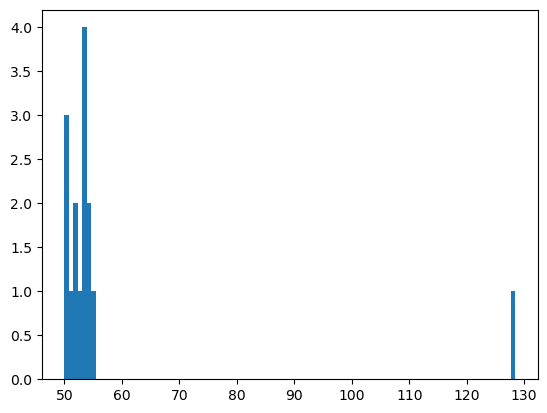

In [8]:
imaging = visits.query('observation_reason == "imaging"')
# Does exposure time start-end still match dark time? looks like yes. 
(imaging['obs_end_mjd'] - imaging['obs_start_mjd']).values * 24 * 60 * 60 - imaging['dark_time'].values
(imaging['visit_gap'] + imaging['dark_time'])[1:].mean(), imaging['visit_gap'][1:].mean()
n,b,p = plt.hist(imaging['visit_gap'][1:], bins=100)

In [9]:
# Look like time between simple imaging visits is 52.6 seconds on average. 
# We can model this as 'readout time' for sim_runner, to ensure that exposures don't get scheduled closer than this. 
# Need to check on comparison with slew time, and if this overlaps with slew or no.
# But might depend on where this is coming from - does overslew get activate for everything? 

In [10]:
t_start = Time(imaging['obs_start_mjd'].values[0], format='mjd', scale='tai').utc
t_end = Time(imaging['obs_end_mjd'].values[-1] + (3/60/60/24), format='mjd', scale='tai').utc
topic = "lsst.sal.Script.logevent_logMessage"
fields = '*'
script = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
topic = "lsst.sal.ATCamera.logevent_endOfImageTelemetry"
fields = ['imageName', 'imageIndex', 'exposureTime', 'darkTime', 'measuredShutterOpenTime', 
              'additionalValues', 'timestampAcquisitionStart', 'timestampDateEnd', 'timestampDateObs']
im = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
im.rename({'imageName': 'filePath', 'additionalValues': 'functionName'}, axis=1, inplace=True)
messages = pd.concat([script, im])
messages.sort_index(inplace=True)
#display(HTML(messages.to_html()))

In [11]:
# I think this identifies timestamp for slew start, overslew start, and when the exposure is done (how accurate are timestamps?)
startslew = messages.dropna(axis=0, subset=['message']).query('message.str.contains("Slew and track")')
overslew = messages.dropna(axis=0, subset=['message']).query('message.str.contains("Overslew")')
expdone = messages.dropna(axis=0, subset=['message']).query('message.str.contains("Completed exposure")')[1:]

In [12]:
# Time for initial slew
slewtime = (overslew.index - startslew.index).values / np.timedelta64(1, 's')
print('initial slew', slewtime.mean())
# Time for overslew
overslewtime = (expdone.index - overslew.index).values / np.timedelta64(1, 's') - 30.2
print('overslew', overslewtime.mean())

initial slew 11.606247285714286
overslew 41.10810742857143


In [13]:
list(zip((slewtime + overslewtime), imaging['visit_gap'].values[1:]))

[(np.float64(53.097537), np.float64(53.684794809669256)),
 (np.float64(53.15275), np.float64(53.691151016391814)),
 (np.float64(51.247785), np.float64(51.82951355818659)),
 (np.float64(54.75153099999999), np.float64(55.301326350308955)),
 (np.float64(52.958587), np.float64(53.56714054942131)),
 (np.float64(54.113306), np.float64(54.70031937584281)),
 (np.float64(49.678987), np.float64(50.252126972191036))]

In [14]:
(slewtime + overslewtime) - imaging['visit_gap'].values[1:]  # .. just to double-check if there's anything else going on, but it mostly seems like the timestamps around the slew match up with the visit_gap

array([-0.58725781, -0.53840102, -0.58172856, -0.54979535, -0.60855355,
       -0.58701338, -0.57313997])

In [15]:
def merge_packed_time_series(
    packed_dataframe,
    base_field,
    stride=1,
    ref_timestamp_col="cRIO_timestamp",
    fmt="unix_tai",
    scale="tai",
):
    """Select fields that are time samples and unpack them into a dataframe.

    Parameters
    ----------
    packed_dataframe : `pandas.DataFrame`
        packed data frame containing the desired data
    base_field :  `str`
        Base field name that will be expanded to query all
        vector entries.
    stride : `int`, optional
        Only use every stride value when unpacking. Must be a factor
        of the number of packed values. (1 by default)
    ref_timestamp_col : `str`, optional
        Name of the field name to use to assign timestamps to unpacked
        vector fields (default is 'cRIO_timestamp').
    fmt : `str`, optional
        Format to give to the `astropy.time.Time` constructor. Defaults to
        'unix_tai' since most internal timestamp columns are in TAI.
    scale : `str`, optional
        Time scale to give to the `astropy.time.Time` constructor. Defaults to
        'tai'.

    Returns
    -------
    result : `pandas.DataFrame`
        A `pandas.DataFrame` containing the results of the query.
    """

    packed_fields = [
        k
        for k in packed_dataframe.keys()
        if k.startswith(base_field) and k[len(base_field) :].isdigit()
    ]
    packed_fields = sorted(
        packed_fields, key=lambda k: int(k[len(base_field) :])
    )  # sort by pack ID
    npack = len(packed_fields)
    if npack % stride != 0:
        raise RuntimeError(
            "Stride must be a factor of the number of packed fields: "
            f"{stride} v. {npack}"
        )
    packed_len = len(packed_dataframe)
    n_used = npack // stride  # number of raw fields being used
    output = np.empty(n_used * packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col].iloc[0])

    if packed_len == 1:
        dt = 0
    else:
        dt = (
            packed_dataframe[ref_timestamp_col].iloc[1]
            - packed_dataframe[ref_timestamp_col].iloc[0]
        ) / npack
    for i in range(0, npack, stride):
        i0 = i // stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i * dt

    timestamps = Time(times, format=fmt, scale=scale)
    return pd.DataFrame(
        {base_field: output, "times": times}, index=timestamps.utc.datetime64
    )

Text(0.5, 1.0, 'Nasmyth2 motor velocity')

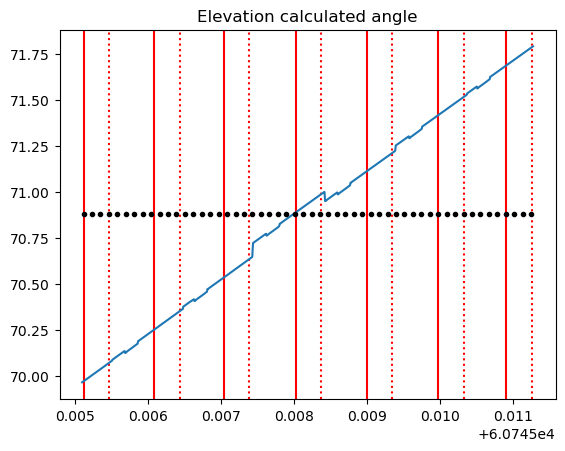

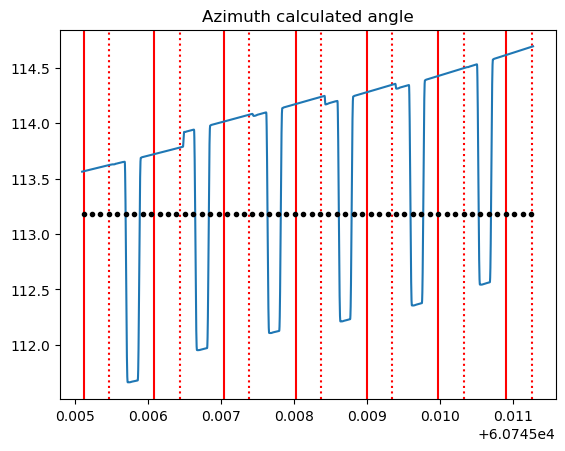

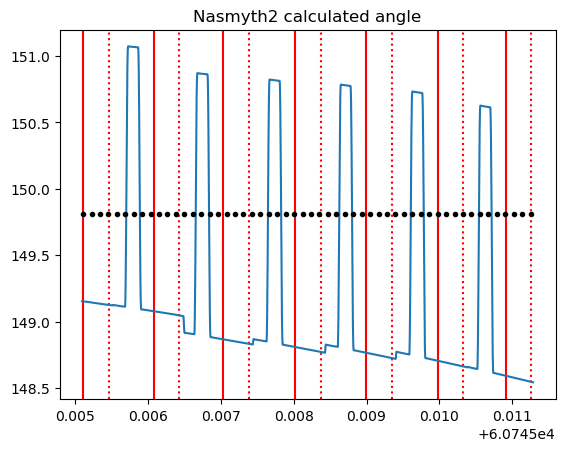

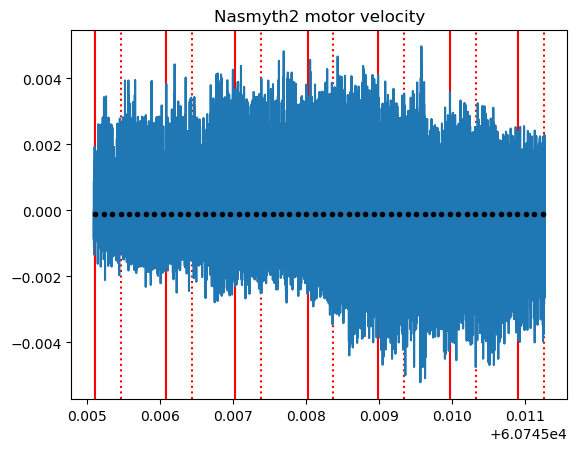

In [63]:
i_start = 1
i_end = 7
t_start = Time(imaging['obs_start_mjd'].values[i_start], format='mjd', scale='tai').utc
t_end = Time(imaging['obs_end_mjd'].values[i_end] + (3/60/60/24), format='mjd', scale='tai').utc
    
topic = "lsst.sal.ATMCS.mount_AzEl_Encoders"
fields = '*'
mount = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
mount_el = merge_packed_time_series(mount, base_field='elevationCalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
mount_az = merge_packed_time_series(mount, base_field='azimuthCalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
times = Time(mount_el['times'], format='unix_tai', scale='tai').mjd

# Encoders are not in the units they claim, and don't have a consistent relationship with calculated values above
# topic = "lsst.sal.ATMCS.azEl_mountMotorEncoders"
# fields = "*"
# encoders = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
# encoders_el = merge_packed_time_series(encoders, base_field="elevationEncoder", stride=1, ref_timestamp_col="cRIO_timestamp", fmt='unix_tai', scale='tai')
# times2 = Time(encoders_el['times'], format='unix_tai', scale='tai').mjd

plt.figure()
for i in range(i_start, i_end+1):
    xs = imaging['obs_start_mjd'].iloc[i]
    xe = imaging['obs_end_mjd'].iloc[i]
    plt.axvline(xs, color='r', linestyle='-')
    plt.axvline(xe, color='r', linestyle=':')
plt.plot(times, mount_el['elevationCalculatedAngle'])
#plt.plot(times2, encoders_el['elevationEncoder'], color='g')
ylims = plt.ylim()
tt = np.arange(imaging['obs_start_mjd'].iloc[i_start], imaging['obs_end_mjd'].iloc[i_end], 10/60/60/24)
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.title("Elevation calculated angle")

plt.figure()
for i in range(i_start, i_end+1):
    xs = imaging['obs_start_mjd'].iloc[i]
    xe = imaging['obs_end_mjd'].iloc[i]
    plt.axvline(xs, color='r', linestyle='-')
    plt.axvline(xe, color='r', linestyle=':')
plt.plot(times, mount_az['azimuthCalculatedAngle'])
ylims = plt.ylim()
tt = np.arange(imaging['obs_start_mjd'].iloc[i_start], imaging['obs_end_mjd'].iloc[i_end], 10/60/60/24)
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.title("Azimuth calculated angle")

topic = "lsst.sal.ATMCS.mount_Nasmyth_Encoders"
fields = '*'
mount = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
mount_nas1 = merge_packed_time_series(mount, base_field='nasmyth1CalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
mount_nas2 = merge_packed_time_series(mount, base_field='nasmyth2CalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
times = Time(mount_nas1['times'], format='unix_tai', scale='tai').mjd

topic = "lsst.sal.ATMCS.measuredMotorVelocity"
fields = "*"
motor = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
motor_nas = merge_packed_time_series(motor, base_field="nasmyth1MotorVelocity", stride=1, ref_timestamp_col="cRIO_timestamp", fmt='unix_tai', scale='tai')
times2 = Time(motor_nas['times'], format='unix_tai', scale='tai').mjd


plt.figure()
for i in range(i_start, i_end+1):
    xs = imaging['obs_start_mjd'].iloc[i]
    xe = imaging['obs_end_mjd'].iloc[i]
    plt.axvline(xs, color='r', linestyle='-')
    plt.axvline(xe, color='r', linestyle=':')
plt.plot(times, mount_nas2['nasmyth2CalculatedAngle'])
ylims = plt.ylim()
tt = np.arange(imaging['obs_start_mjd'].iloc[i_start], imaging['obs_end_mjd'].iloc[i_end], 10/60/60/24)
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.title("Nasmyth2 calculated angle")


plt.figure()
for i in range(i_start, i_end+1):
    xs = imaging['obs_start_mjd'].iloc[i]
    xe = imaging['obs_end_mjd'].iloc[i]
    plt.axvline(xs, color='r', linestyle='-')
    plt.axvline(xe, color='r', linestyle=':')
plt.plot(times2, motor_nas['nasmyth1MotorVelocity'])
ylims = plt.ylim()
tt = np.arange(imaging['obs_start_mjd'].iloc[i_start], imaging['obs_end_mjd'].iloc[i_end], 10/60/60/24)
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.title("Nasmyth2 motor velocity")

In [328]:
# Look at one of the other targets for spectroscopy
visits.groupby('target_name').count()['seq_num']

target_name
HD185975        12
HD77020         59
Photo08000-1     8
Name: seq_num, dtype: int64

12


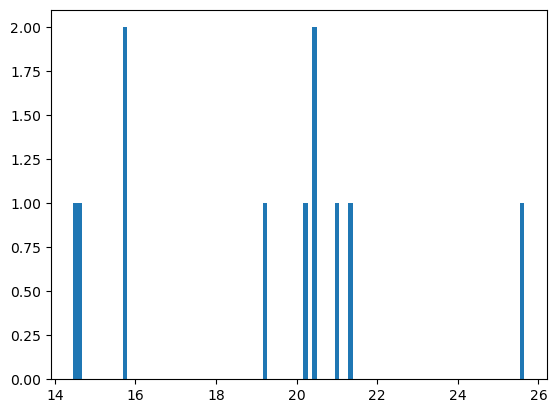

In [32]:
target = 'HD185975'  
# This was a BLOCK-311 
spec = visits.query('target_name == @target') 
# Does exposure time start-end still match dark time? looks like yes. 
(spec['obs_end_mjd'] - spec['obs_start_mjd']).values * 24 * 60 * 60 - spec['dark_time'].values
# What do the visit gaps look like
n,b,p = plt.hist(spec['visit_gap'][1:], bins=100)
print(len(spec))

In [36]:
spec[cols + ['alt']]

,seq_num,physical_filter,s_ra,s_dec,altitude,azimuth,sky_rotation,obs_start,obs_end,exp_time,dark_time,visit_gap,img_type,science_program,observation_reason,target_name,alt
visit_id,,,,,,,,,,,,,,,,,
2025031000181,181,empty~holo4_003,307.075,-87.471944,62.110869,-178.780866,247.853084,2025-03-11T00:29:09.996000,2025-03-11T00:29:40.221000,30.0,30.225080,25.167621,OBJECT,spec-survey,None,HD185975,27.889131
2025031000182,182,BG40_65mm_1~holo4_003,307.075,-87.471944,62.114325,-178.789713,247.854317,2025-03-11T00:29:54.677000,2025-03-11T00:30:24.901000,30.0,30.224485,14.455604,OBJECT,spec-survey,None,HD185975,27.885675
2025031000183,183,OG550_65mm_1~holo4_003,307.075,-87.471944,62.117815,-178.798777,247.853093,2025-03-11T00:30:40.622000,2025-03-11T00:31:10.851000,30.0,30.228387,15.720827,OBJECT,spec-survey,None,HD185975,27.882185
2025031000184,184,empty~blue300lpmm_qn1,307.075,-87.471944,62.122786,-178.811766,247.852088,2025-03-11T00:31:31.319000,2025-03-11T00:32:31.545000,60.0,60.225234,20.468670,OBJECT,spec-survey,x_offset_0,HD185975,27.877214
2025031000185,185,empty~blue300lpmm_qn1,307.075,-87.471944,62.114839,-178.826317,247.852390,2025-03-11T00:32:50.779000,2025-03-11T00:33:51.005000,60.0,60.226027,19.234152,OBJECT,spec-survey,x_offset_-50,HD185975,27.885161
2025031000186,186,empty~blue300lpmm_qn1,307.075,-87.471944,62.148435,-178.844396,247.850787,2025-03-11T00:34:11.279000,2025-03-11T00:35:11.509000,60.0,60.230032,20.274099,OBJECT,spec-survey,x_offset_50,HD185975,27.851565
2025031000193,193,empty~holo4_003,307.075,-87.471944,62.228141,-179.128688,254.676982,2025-03-11T00:56:54.542000,2025-03-11T00:57:24.770000,30.0,30.227508,25.646814,OBJECT,spec-survey,None,HD185975,27.771859
2025031000194,194,BG40_65mm_1~holo4_003,307.075,-87.471944,62.230660,-179.137959,254.676763,2025-03-11T00:57:39.394000,2025-03-11T00:58:09.618000,30.0,30.224057,14.624374,OBJECT,spec-survey,None,HD185975,27.769340
2025031000195,195,OG550_65mm_1~holo4_003,307.075,-87.471944,62.233262,-179.147422,254.676129,2025-03-11T00:58:25.325000,2025-03-11T00:58:55.552000,30.0,30.226438,15.706875,OBJECT,spec-survey,None,HD185975,27.766738


2025-03-11 00:35:00.000 2025-03-11 00:36:00.000


Text(0.5, 1.0, 'Nasmyth2 motor velocity')

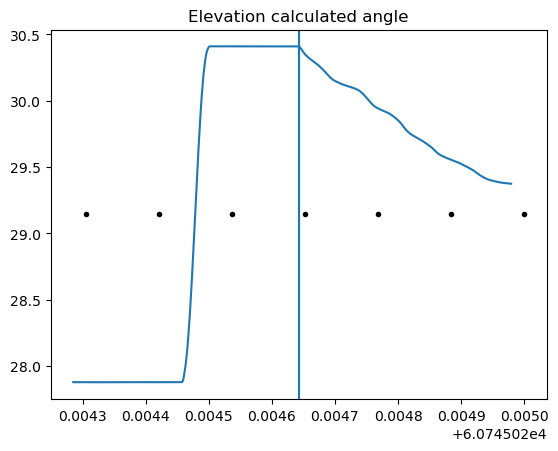

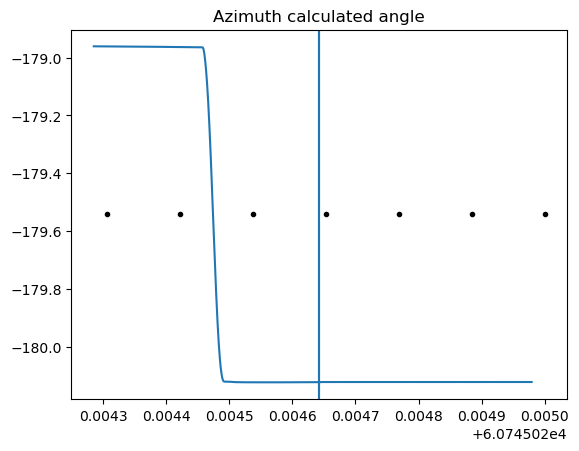

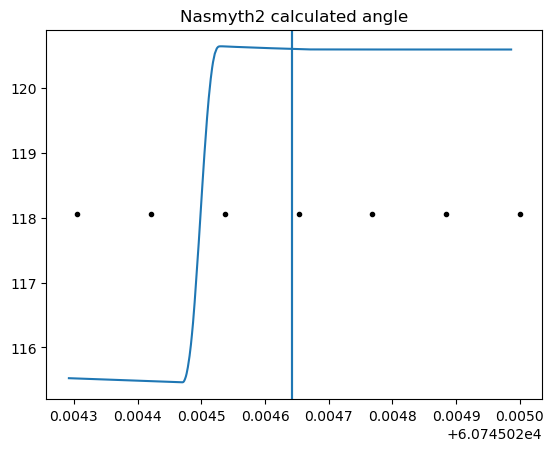

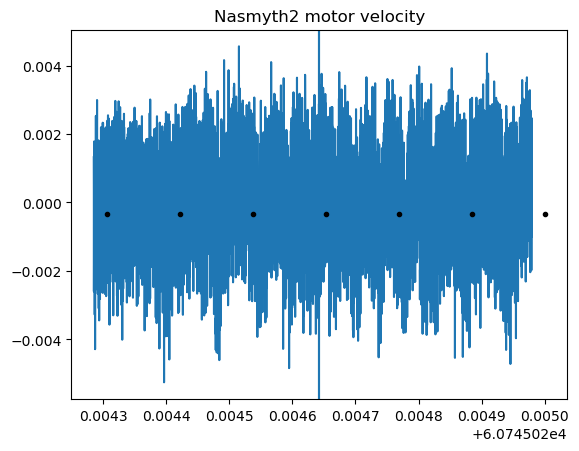

In [71]:
i_start = 1
i_end = 11
q = spec
t_start = Time(q['obs_start_mjd'].values[i_start], format='mjd', scale='tai').utc
t_end = Time(q['obs_end_mjd'].values[i_end] + (3/60/60/24), format='mjd', scale='tai').utc

t_start = Time("2025-03-11 00:35:00", format='iso', scale='utc').utc
t_end = t_start + TimeDelta(60, format='sec')
#t_end = Time("2025-03-11 00:43:42.87962", format="iso", scale="utc").utc
t1 = Time("2025-03-11 00:35:29.084787", format='iso', scale='utc').utc.mjd
t2 = t1
#t2 = Time("2025-03-11 00:43:42.879615", format='iso', scale='utc').utc.mjd

print(t_start.iso, t_end.iso)
topic = "lsst.sal.ATMCS.mount_AzEl_Encoders"
fields = '*'
mount = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
mount_el = merge_packed_time_series(mount, base_field='elevationCalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
mount_az = merge_packed_time_series(mount, base_field='azimuthCalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
times = Time(mount_el['times'], format='unix_tai', scale='tai').utc.mjd

# Encoders are not in the units they claim, and don't have a consistent relationship with calculated values above
# topic = "lsst.sal.ATMCS.azEl_mountMotorEncoders"
# fields = "*"
# encoders = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
# encoders_el = merge_packed_time_series(encoders, base_field="elevationEncoder", stride=1, ref_timestamp_col="cRIO_timestamp", fmt='unix_tai', scale='tai')
# times2 = Time(encoders_el['times'], format='unix_tai', scale='tai').mjd

plt.figure()
# for i in range(i_start, i_end+1):
#     xs = q['obs_start_mjd'].iloc[i]
#     xe = q['obs_end_mjd'].iloc[i]
#     plt.axvline(xs, color='r', linestyle='-')
#     plt.axvline(xe, color='r', linestyle=':')
plt.plot(times, mount_el['elevationCalculatedAngle'])
#plt.plot(times2, encoders_el['elevationEncoder'], color='g')
ylims = plt.ylim()
#tt = np.arange(q['obs_start_mjd'].iloc[i_start], q['obs_end_mjd'].iloc[i_end], 10/60/60/24)
tt = np.arange(t_start.utc.mjd, t_end.utc.mjd, 10/60/60/24)
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.axvline(t1)
plt.axvline(t2)
plt.title("Elevation calculated angle")

plt.figure()
# for i in range(i_start, i_end+1):
#     xs = q['obs_start_mjd'].iloc[i]
#     xe = q['obs_end_mjd'].iloc[i]
#     plt.axvline(xs, color='r', linestyle='-')
#     plt.axvline(xe, color='r', linestyle=':')
plt.plot(times, mount_az['azimuthCalculatedAngle'])
ylims = plt.ylim()
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.axvline(t1)
plt.axvline(t2)
plt.title("Azimuth calculated angle")

topic = "lsst.sal.ATMCS.mount_Nasmyth_Encoders"
fields = '*'
mount = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
mount_nas1 = merge_packed_time_series(mount, base_field='nasmyth1CalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
mount_nas2 = merge_packed_time_series(mount, base_field='nasmyth2CalculatedAngle', stride=1, ref_timestamp_col='cRIO_timestamp', fmt='unix_tai', scale='tai')
times = Time(mount_nas1['times'], format='unix_tai', scale='tai').utc.mjd

topic = "lsst.sal.ATMCS.measuredMotorVelocity"
fields = "*"
motor = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)
motor_nas = merge_packed_time_series(motor, base_field="nasmyth1MotorVelocity", stride=1, ref_timestamp_col="cRIO_timestamp", fmt='unix_tai', scale='tai')
times2 = Time(motor_nas['times'], format='unix_tai', scale='tai').utc.mjd


plt.figure()
# for i in range(i_start, i_end+1):
#     xs = q['obs_start_mjd'].iloc[i]
#     xe = q['obs_end_mjd'].iloc[i]
#     plt.axvline(xs, color='r', linestyle='-')
#     plt.axvline(xe, color='r', linestyle=':')
plt.plot(times, mount_nas2['nasmyth2CalculatedAngle'])
ylims = plt.ylim()
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.axvline(t1)
plt.axvline(t2)
plt.title("Nasmyth2 calculated angle")


plt.figure()
# for i in range(i_start, i_end+1):
#     xs = q['obs_start_mjd'].iloc[i]
#     xe = q['obs_end_mjd'].iloc[i]
#     plt.axvline(xs, color='r', linestyle='-')
#     plt.axvline(xe, color='r', linestyle=':')
plt.plot(times2, motor_nas['nasmyth1MotorVelocity'])
ylims = plt.ylim()
plt.plot(tt, np.ones(len(tt))*np.mean(ylims), 'k.')
plt.axvline(t1)
plt.axvline(t2)
plt.title("Nasmyth2 motor velocity")

In [75]:
t_start = sunset
t_end = sunrise
topic = "lsst.sal.Script.logevent_logMessage"
fields = '*'
script = await endpoints['efd'].select_time_series(topic, fields, t_start, t_end)

In [85]:
#[float(m.split('by')[-1].split(' degrees')[0]) for m in script.query("message.str.contains('Overslew') and not message.str.contains('Skipping')")['message']]